# 9. Hypothesis Testing

In this chapter, we will look at hypothesis testing in R. We will start with single sample distributions and tests, and then we will look at hypothesis tests for comparing two samples. Examples will include testing for positive correlations, performing two sample paired t-tests, and testing for equal variance among groups. The data we will use in this section comes from the Texas Health and Human Services Department and includes the reported number of induced terminations of pregnancy (ITOPs) from 2016 to 2021, stratified by both race and county. The data also contains the rate of abortions per 1000 females aged 15-49. Read the data documentation to see the full variable descriptions.

We will use the `tidyverse`, `gt`, and `gtsummary` packages to help manipulate and summarize the data. The `car` package contains the function `leveneTest()` to implement a Levene’s test for homogeneity of variance across groups, and all other hypothesis tests are available in base R.

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(RforHDSdata))
suppressPackageStartupMessages(library(gt))
suppressPackageStartupMessages(library(gtsummary))
data(tex_itop)

## Univariate Distributions and One Sample Tests

Let's begin by looking at a single outcome of interest - the number of induced terminations of pregnancy (referred to as ITOPs or abortions below) in 2021 per 1000 females ages 15-49 in each county. We use the number of females ages 15-49 as a proxy to scale the number of abortions by the population size, though this is not truly reflective of the number of people who can give birth in each county. 

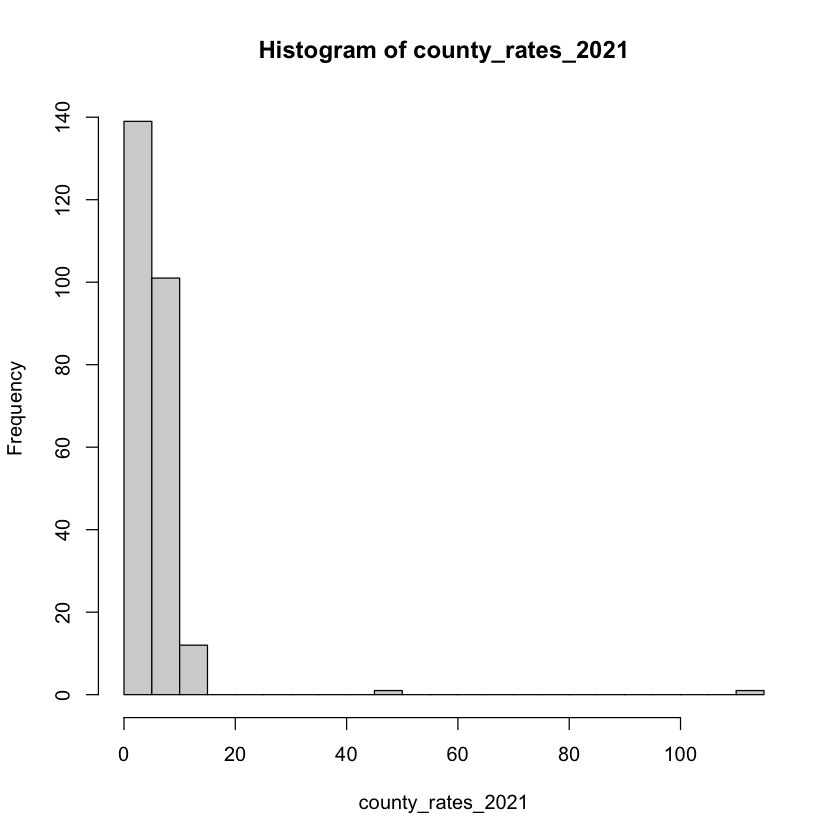

In [2]:
county_rates_2021 <- tex_itop$total_rate[tex_itop$year == 2021]
hist(county_rates_2021, breaks = 35)

We can see in the figure that this is a heavy-tailed distribution. Below, we find the 10 counties with the highest rates and see that there are some counties that very few total abortions but that have some of the highest abortion rates. This indicates a small population. On the other hand, we also observe Harris county, which contains the city of Houston and has both a high total abortion count and a high abortion rate. 

In [3]:
tex_itop %>% 
  filter(year==2021) %>% 
  slice_max(n=10, total_rate) %>%
  dplyr::select(c(county, total_itop, total_rate))

county,total_itop,total_rate
<chr>,<dbl>,<dbl>
Loving,1,111.11111
Terrell,5,50.00000
Concho,4,13.88889
Harris,14122,13.49705
Irion,3,12.93103
Real,4,12.50000
Bexar,5180,11.91413
Menard,3,11.76471
Dallas,6867,11.72197


Some of the counties are so small that we may want to consider dropping them from our analysis. In particular, the rates in Loving County and Terrel County are so high that we might consider them to be outliers. For this one sample analysis, however, we do not remove them. If we wanted to estimate the mean abortion rate among counties $\mu$ we can do so by simply using the `mean()` function. For reference, the [CDC](https://www.cdc.gov/reproductivehealth/data_stats/abortion.htm) estimated the national abortion rate in 2020 to be 11.2 abortions per 1,000 women aged 15–44 years.

In [4]:
mean(county_rates_2021, na.rm=TRUE)

[1] 5.166244

Within R we can also calculate a confidence interval for this mean. Recall that a $(1-\alpha)$%  confidence interval for the mean is given by the equation below, where $\hat{\mu}$ is our sample mean, $\hat{\sigma}^2$ is the sample variance, and $n$ is the number of observations.
$$\hat{\mu} \pm z_{1-\alpha/2} \cdot \frac{\hat{\sigma}}{\sqrt{n}}$$

Below, we use this formula to calculate a 95% confidence interval for the mean abortion rate among counties:

In [5]:
est_mean <- mean(county_rates_2021, na.rm=TRUE)
est_sd <- sd(county_rates_2021)
z_alpha <- dnorm(1-0.05/2)
n <- length(county_rates_2021)
c(est_mean - z_alpha*est_sd/sqrt(n), est_mean + z_alpha*est_sd/sqrt(n))

[1] 5.043713 5.288775

If we want to display this nicely, we can use the `round()` function, which allows us to specify a number of digits to be displayed, and the `paste()` function, which creates a single character string from multiple inputs. 

In [6]:
lower <- round(est_mean - z_alpha*est_sd/sqrt(n),3)
upper <- round(est_mean + z_alpha*est_sd/sqrt(n),3)
paste("Confidence Interval: (", lower, ",", upper, ")")

[1] "Confidence Interval: ( 5.044 , 5.289 )"

Suppose that we wanted to run a hypothesis test to compare the mean to a pre-determined value. In particular, the Texas Heartbeat Act was introduced in 2021 and drastically reduced the number of eligible abortions. We could test whether there were significantly fewer abortions in 2021 compared to 2020 using a one-sided t-test. Our null hypothesis is that $\mu \geq 6.23$, the mean abortion rate in 2020. To run this hypothesis test, we use the `t.test()` function. For a one sample t-test, we need to specify our sample `x`, the alternative hypothesis `alternative` (default is a two-sided test), the true value of the mean `mu` (default 0), and a confidence level `conf.level` (default 0.95). Below, we run this t-test, and we can see from the result that we reject the null hypothesis at the 0.05 level and observe a statistically significant decline in the abortion rate in 2021. 

In [7]:
t.test(county_rates_2021, alternative = "less", mu = 6.23, 
       conf.level=0.95)


	One Sample t-test

data:  county_rates_2021
t = -2.1532, df = 253, p-value = 0.01612
alternative hypothesis: true mean is less than 6.23
95 percent confidence interval:
     -Inf 5.981853
sample estimates:
mean of x 
 5.166244 


The output for this test is printed above. If we want to reference these values, we will need to save the result. The object `t_test_res` is a list that contains information about the statistic, p-value, confidence interval, etc. The list of outputs are similar to other test objects, so it is useful to look at what is contained in each by reading the test documentation (`?t.test`). Below, we find the p-value from `t_test_res`. 

In [8]:
t_test_res <- t.test(county_rates_2021, alternative = "less", mu = 6.23, 
       conf.level=0.95)
names(t_test_res)

[1] "statistic"   "parameter"   "p.value"     "conf.int"    "estimate"   
 [6] "null.value"  "stderr"      "alternative" "method"      "data.name"

In [9]:
t_test_res$p.value

[1] 0.01612495

### Practice Question

Test whether there were significantly more abortions in 2019 compared to 2020 using a one-sided t-test. Your t statistic should be -6.4736.

In [10]:
# Insert your solution here:

One thing to consider is that the `t.test()` function assumes that the sample `x` comes from a normal distribution. The one-sample Wilcoxon signed rank test is a non-parametric alternative to the one-sample t-test that can be used to compare the median value of a sample to a theoretical value without assuming that the data is normally distributed. This test can be performed using the `wilcox.test()` function and takes in the same arguments as the `t.test()` function. Below, we can see that we again reject the null hypothesis at the 0.05 level and conclude that the median abortion rate in 2021 was significantly lower than 5.14, which was the median rate in 2020.

In [11]:
wilcox_res <- wilcox.test(county_rates_2021, alternative = "less", 
                          mu = 5.14, conf.level=0.95)
wilcox_res
wilcox_res$p.value


	Wilcoxon signed rank test with continuity correction

data:  county_rates_2021
V = 12807, p-value = 0.001935
alternative hypothesis: true location is less than 5.14


[1] 0.001934671

## Correlation and Covariance

We now look at two sample tests. To start, we look at the 2020 and 2021 rates by county. We pivot our data into a wider format in order to create 2020 and 2021 rate columns, and, this time, we filter out the Loving and Terrel counties to remove outliers. We then create a scatter plot of 2021 vs. 2020 rates and observe a linear correlation between the two.

In [12]:
county_rates <- tex_itop %>%
  dplyr::select(c(county, total_rate, year)) %>%
  filter(!(county %in% c("Terrell", "Loving")), 
         year %in% c(2020, 2021)) %>%
  pivot_wider(names_from = year, values_from = total_rate) %>%
  na.omit() %>%
  rename("y2020"="2020", "y2021"="2021")
head(county_rates)

county,y2020,y2021
<chr>,<dbl>,<dbl>
Anderson,6.840638,5.0671396
Andrews,1.847453,0.7917656
Angelina,5.810719,5.9961674
Aransas,3.435353,7.1830106
Archer,1.465201,0.7326007
Armstrong,0.000000,0.0000000


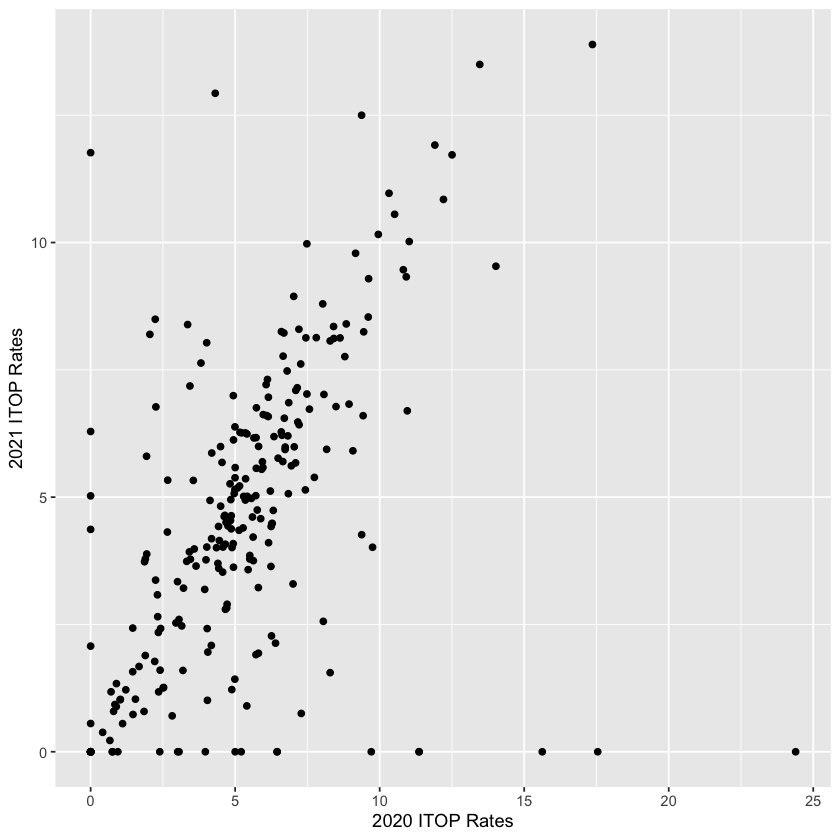

In [13]:
ggplot(county_rates) + 
 geom_point(aes(x=y2020,y=y2021)) +
 labs(x="2020 ITOP Rates", y="2021 ITOP Rates")

We have seen before how to calculate the correlation between two columns using the `cor()` function. We can also calculate the covariance using the `cov()` function. As suspected, there is a positive correlation. The estimated covariance is around 5.2.

In [14]:
cor(county_rates$y2020, county_rates$y2021)
cov(county_rates$y2020, county_rates$y2021)

[1] 0.4995677

[1] 5.198533

Besides calculating the value of the correlation, we can also test whether this correlation is significantly different from zero. The function `cor.test()` tests for association between paired samples, using either Pearson's product moment correlation coefficient, Kendall's $\tau$, or Spearman's $\rho$. Similar to the `t.test()` and `wilcox.test()` functions, we can also specify the `alternative` and `conf.level` arguments. Below, we test whether there is a non-zero correlation between the 2020 and 2021 county rates using Pearson's product-moment correlation. We can see from the resulting p-value that we can reject the null hypothesis that the correlation is zero and conclude that it is instead significantly different than zero. This time we also print the computed confidence interval for our estimate.

In [15]:
cor_test_res <- cor.test(county_rates$y2020, 
                         county_rates$y2021, method="pearson")
cor_test_res


	Pearson's product-moment correlation

data:  county_rates$y2020 and county_rates$y2021
t = 9.1182, df = 250, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4007334 0.5869089
sample estimates:
      cor 
0.4995677 


In [16]:
cor_test_res$conf.int

[1] 0.4007334 0.5869089
attr(,"conf.level")
[1] 0.95

## Two Sample Tests for Continuous Variables

If we wanted to directly compare the difference between 2020 and 2021 rates, we could use a two sample test. In this case, because our samples are paired by county, we can use a two sample paired t-test. Specifically, we use a two-sided test to test the null hypothesis that the rates are equal by specifying two different vectors `x` and `y`. Note that we used the default values of `mu=0` and `alternative="two.sided"`. Additionally, we used the default value `var.equal=FALSE`, which implies that the samples may have different variances. From the results below, we reject the null hypothesis that the two county rates are equal at the 0.05 level. We also print a 95% confidence interval of the difference in means.

In [17]:
t_test_two_res <- t.test(x=county_rates$y2020, y=county_rates$y2021)
t_test_two_res
t_test_two_res$conf.int


	Welch Two Sample t-test

data:  county_rates$y2020 and county_rates$y2021
t = 2.4693, df = 496.93, p-value = 0.01387
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1453563 1.2775189
sample estimates:
mean of x mean of y 
 5.279354  4.567916 


[1] 0.1453563 1.2775189
attr(,"conf.level")
[1] 0.95

In the `tex_itop` dataset, each county has also been categorized by whether it was urban or rural. Suppose we want to compare the change in abortion rates from 2020 to 2021 between rural and urban counties. First, we create a variable describing the rate change between these years using the code below. We choose to use the change in rate rather than percent change to avoid infinite or undefined values.

In [18]:
county_rates_type <- tex_itop %>%
  dplyr::select(c(county, urban, county_type, total_rate, year)) %>%
  filter(total_rate < 15, year %in% c(2020, 2021)) %>%
  pivot_wider(names_from = year, values_from = total_rate) %>%
  na.omit() %>%
  rename("y2020"="2020", "y2021"="2021") %>%
  mutate(rate_change = (y2021-y2020)) 

We again use a two-sample two-sided t-test, but this time the data is not paired. Below, we show an alternative way to specify a t-test test below using a formula `lhs ~ rhs`, where `lhs` is a numeric column and `rhs` is a factor column with two levels. We must also specify the data in this case. From the R output in this case, we would fail to reject the null hypothesis at the 0.05 level and conclude that the rate changes for urban and rural counties are not significantly different. We also print the estimates used in the t-test using `estimate`, which shows the estimated mean in both groups.

In [19]:
t_test_unpaired <- t.test(rate_change~urban, data=county_rates_type)
t_test_unpaired
t_test_unpaired$estimate


	Welch Two Sample t-test

data:  rate_change by urban
t = 0.1268, df = 205.36, p-value = 0.8992
alternative hypothesis: true difference in means between group Rural and group Urban is not equal to 0
95 percent confidence interval:
 -0.4950663  0.5631197
sample estimates:
mean in group Rural mean in group Urban 
         -0.4685861          -0.5026127 


mean in group Rural mean in group Urban 
         -0.4685861          -0.5026127

Note that this yields the same results as if we had specified the data using two vectors `x` and `y`. 

In [20]:
x <- county_rates_type$rate_change[county_rates_type$urban == 'Urban']
y <- county_rates_type$rate_change[county_rates_type$urban == 'Rural']
t.test(x=x, y=y, paired = FALSE) 


	Welch Two Sample t-test

data:  x and y
t = -0.1268, df = 205.36, p-value = 0.8992
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5631197  0.4950663
sample estimates:
 mean of x  mean of y 
-0.5026127 -0.4685861 


Besides a t-test, we can also use a two-sample Wilcoxon non-parametric test using the `wilcox.test()` function, which has the same arguments as the function `t.test()`. Both the `t.test()` and `wilcox.test()` can only compare two groups. When we want to compare two or more independent samples, we can use a Kruskal-Wallis rank sum test using the `kruskal.test()` function or a one-way analysis of variance (ANOVA) using the `aov()` function. 

This time we use the column `county_type`, which is an indicator for whether the county is urban, suburban, or rural according to the RUCC (rural-urban continuum codes) from the U.S. Department of Agriculture. For the `kruskal.test()` function, we can either specify the arguments `formula` (`rate_change ~ county_type`) and `data` (`county_rates_type`) or we can specify two vectors: `x`, a numeric vector, and `g`, a factor representing the group. For the `aov()` function, we specify the test using a formula and the data. To see the p-value, we have to use the `summary()` function to print the result. Again, both tests suggest that we fail to reject the null hypothesis at the 0.05 level.

In [21]:
kruskal.test(county_rates_type$rate_change, 
             county_rates_type$county_type)


	Kruskal-Wallis rank sum test

data:  county_rates_type$rate_change and county_rates_type$county_type
Kruskal-Wallis chi-squared = 2.3715, df = 2, p-value = 0.3055


In [22]:
aov_res <- aov(rate_change~county_type, data=county_rates_type)
summary(aov_res)

             Df Sum Sq Mean Sq F value Pr(>F)
county_type   2    6.7   3.364   0.533  0.588
Residuals   245 1546.6   6.313               

### Practice Question

Use an appropriate test to determine whether the ITOP rates in 2016 significantly differed by race. The test statistic should be 264.27 with associated p-value < 2.2e-16.

In [23]:
# Insert your solution here:

### Two Sample Variance Tests

We could also test whether the variance of a continous variable is equal between groups. To start, we compare the variance in abortion rates in 2021 between urban and rural counties using an F test. Our null hypothesis for this test is that the variance in both groups is equal. The function `var.test()` implements an F test and has the same main arguments as the `t.test()` function: vectors `x` and `y` OR a `formula` and `data`, the alternative hypothesis `alternative`, and `conf.level`. Additionally, we can specify the hypothesized ratio of the variances through the arugment `ratio` (default value 1). Note that this function assumes that the two samples come from normally distributed populations. We fail to reject the null hypothesis that the variance in rates are equal at the 0.05 level and print the estimate of the ratio of variances, which is around 1.11.

In [24]:
f_test <- var.test(y2021 ~ urban, county_rates_type)
f_test
f_test$estimate


	F test to compare two variances

data:  y2021 by urban
F = 1.117, num df = 187, denom df = 59, p-value = 0.6307
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7194388 1.6566899
sample estimates:
ratio of variances 
          1.116952 


ratio of variances 
          1.116952

Lastly, we implement a Levene's test to test whether group variances are equal when there are more than two groups. This test can be specified using a formula and data set, as below, or by providing two vectors `y`, a numeric vector, and `g`, a vector specifying the groups. This test is from the `car` package and has slightly different output than other tests. In particular, to access the p-value, we need to access the value named `'Pr(>F)'`. In this case, we actually do reject the null hypothesis at the 0.05 level.

In [25]:
levene_test <- leveneTest(y2021 ~ as.factor(county_type), 
                              county_rates_type)
print(levene_test)
levene_test[['Pr(>F)']]

Levene's Test for Homogeneity of Variance (center = median)
       Df F value  Pr(>F)  
group   2  3.4142 0.03448 *
      245                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 0.03447642         NA

## Two Sample Tests for Categorical Variables

In the two sample tests above, we were comparing the distributions of continuous variables. We now look at comparing distributions of categorical variables. We will first categorize counties by their abortion rate in 2020 being above or below 11.2, which was the national average rate that year. We display the distribution of this variable by the urban/rural grouping using a contingency table below.

In [26]:
county_rates_type$below_nat_avg <- 
  ifelse(county_rates_type$y2020 > 11.2, "Above Nat Avg", 
         "Below Nat Avg")
table(county_rates_type$below_nat_avg, county_rates_type$urban)

               
                Rural Urban
  Above Nat Avg     3     4
  Below Nat Avg   185    56

We can use a Fisher's exact test to test whether the classifications of being above and below the national average and being rural and urban are associated with each other. In this case, the null hypothesis is that the odds or being below the national average is equal between rural and urban counties. The `fisher.test()` function can either take in a contingency table as a matrix or can be specified by two factor vectors `x` and `y`, which is how we implement it below. Additionally, there is the option to specify the `alternative` and `conf.level` arguments. We do not see a statistically significant difference between urban and rural counties at the 0.05 level with the estimated odds ratio is around 0.23. 

In [27]:
fisher_test <- fisher.test(county_rates_type$urban, 
                           county_rates_type$below_nat_avg)
fisher_test
fisher_test$estimate


	Fisher's Exact Test for Count Data

data:  county_rates_type$urban and county_rates_type$below_nat_avg
p-value = 0.06063
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.03253238 1.39553277
sample estimates:
odds ratio 
  0.228734 


odds ratio 
  0.228734

An alternative test is a Pearson's Chi-Squared test, which can be used for large sample sizes. The counts of rural and urban counties in the 'Above Nat Avg' category are very small, so we recategorize our outcome to be at or above Texas's average to avoid this complication. The `chisq.test()` function also takes in a contingency table as a matrix or can be specified by two factor vectors `x` and `y`. Another useful argument is `correct` (default is TRUE) which indicates whether to apply a continuity correction. For this test, we observe a statistically significant difference in the proportion of counties above the national average between rural and urban counties and reject the null hypothesis at the 0.05 level.

In [28]:
tex_mean <- mean(county_rates_type$y2020)
county_rates_type$below_tex_avg <- 
  ifelse(county_rates_type$y2020 > tex_mean, "Above Texas Ave", 
         "Below Texas Ave")
table(county_rates_type$below_tex_avg, county_rates_type$urban)

                 
                  Rural Urban
  Above Texas Ave    84    39
  Below Texas Ave   104    21

In [29]:
chi_sq <- chisq.test(county_rates_type$below_tex_avg, 
           county_rates_type$urban)
chi_sq
chi_sq$p.value


	Pearson's Chi-squared test with Yates' continuity correction

data:  county_rates_type$below_tex_avg and county_rates_type$urban
X-squared = 6.7212, df = 1, p-value = 0.009527


[1] 0.009527417

### Practice Question

Repeat the Chi-Squared test, but this time use the RUCC codes instead of the `urban` column. You should get a p-value of 0.2799. Think about what could explain the difference between these results.

In [30]:
# Insert your solution here:

## Adding Hypothesis Tests to Summary Tables

In [Chapter 4](https://alicepaul.github.io/r-for-health-data-science/book/4_exploratory_analysis.html), we used the `gt` and `gtsummary` packages to create summary tables of variables. When creating a stratified table (done by add the `by` argument), we can automatically add p-values for hypothesis tests comparing across populations using the `add_p()` function. By default, the `add_p()` function uses a Kruskal-Wallis rank sum test for continuous variables (or a Wilcoxon rank sum test when the `by` variable has two levels) and uses a Chi-Squared Contingency Table Test for categorical variables (or a Fisher's Exact Test for categorical variables with any expected cell count less than five). The chosen test(s) are displayed as footnotes.

In [31]:
tbl_summary(tex_itop, include = c(total_rate, white_rate, asian_rate, 
                                  hispanic_rate, black_rate, 
                                  native_american_rate),
           by = "year", statistic = list(all_continuous() ~ "{mean} ({sd})")) %>% 
  add_p() %>%
  as_gt() %>% 
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

We observe that a Kruskal-Wallis rank sum test was used to compare abortion rates across year for each racial group. All of the reported p-values are above 0.05 so overall it indicates that there were not statistically significant changes across years in the abortion rate. 

## Recap Video

<div class="video-container">
    <iframe width="700" height="500" src="https://www.youtube.com/embed/3vyCeUdSS6U" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>
</div>


## Exercises

For the following exercises, we will be using the `pain` data from the `RforHDSdata` package.

In [32]:
data(pain)
names(pain)

[1] "PATIENT_NUM"                      "X101"                            
 [3] "X102"                             "X103"                            
 [5] "X104"                             "X105"                            
 [7] "X106"                             "X107"                            
 [9] "X108"                             "X109"                            
[11] "X110"                             "X111"                            
[13] "X112"                             "X113"                            
[15] "X114"                             "X115"                            
[17] "X116"                             "X117"                            
[19] "X118"                             "X119"                            
[21] "X120"                             "X121"                            
[23] "X122"                             "X123"                            
[25] "X124"                             "X125"                            
[27] "X126"                             "X127"                            
[29] "X128"                             "X129"                            
[31] "X130"                             "X131"                            
[33] "X132"                             "X133"                            
[35] "X134"                             "X135"                            
[37] "X136"                             "X201"                            
[39] "X202"                             "X203"                            
[41] "X204"                             "X205"                            
[43] "X206"                             "X207"                            
[45] "X208"                             "X209"                            
[47] "X210"                             "X211"                            
[49] "X212"                             "X213"                            
[51] "X214"                             "X215"                            
[53] "X216"                             "X217"                            
[55] "X218"                             "X219"                            
[57] "X220"                             "X221"                            
[59] "X222"                             "X223"                            
[61] "X224"                             "X225"                            
[63] "X226"                             "X227"                            
[65] "X228"                             "X229"                            
[67] "X230"                             "X231"                            
[69] "X232"                             "X233"                            
[71] "X234"                             "X235"                            
[73] "X236"                             "X237"                            
[75] "X238"                             "PAIN_INTENSITY_AVERAGE"          
[77] "PROMIS_PHYSICAL_FUNCTION"         "PROMIS_PAIN_BEHAVIOR"            
[79] "PROMIS_DEPRESSION"                "PROMIS_ANXIETY"                  
[81] "PROMIS_SLEEP_DISTURB_V1_0"        "PROMIS_PAIN_INTERFERENCE"        
[83] "GH_MENTAL_SCORE"                  "GH_PHYSICAL_SCORE"               
[85] "AGE_AT_CONTACT"                   "BMI"                             
[87] "CCI_TOTAL_SCORE"                  "PAIN_INTENSITY_AVERAGE.FOLLOW_UP"
[89] "PAT_SEX"                          "PAT_RACE"                        
[91] "CCI_BIN"                          "MEDICAID_BIN"

1. Determine whether the presence or absence of follow-up information is significantly associated with the initial average pain intensity. What do the results suggest?

In [33]:
pain_df <- pain[complete.cases(subset(pain, select=-c(PAIN_INTENSITY_AVERAGE.FOLLOW_UP))), ]
pain_df$HAS_FOLLOW_UP <- !is.na(pain_df$PAIN_INTENSITY_AVERAGE.FOLLOW_UP)
t.test(PAIN_INTENSITY_AVERAGE~HAS_FOLLOW_UP, data=pain_df)


	Welch Two Sample t-test

data:  PAIN_INTENSITY_AVERAGE by HAS_FOLLOW_UP
t = 2.7403, df = 4447.1, p-value = 0.006163
alternative hypothesis: true difference in means between group FALSE and group TRUE is not equal to 0
95 percent confidence interval:
 0.03676924 0.22165196
sample estimates:
mean in group FALSE  mean in group TRUE 
           6.641022            6.511811 


2. First, plot `PROMIS_PAIN_BEHAVIOR` grouped by race (you can use the `PAT_RACE_CAT` variable that we defined in [Chapter 7](https://alicepaul.github.io/r-for-health-data-science/book/7_visualization_ggplot.html). What do you observe? Next, choose an appropriate test to determine whether this variable differs significantly by race.

Warning message:
“The dot-dot notation (`..scaled..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(scaled)` instead.”


               Df Sum Sq Mean Sq F value Pr(>F)    
PAT_RACE_CAT    2   2066  1033.2   100.5 <2e-16 ***
Residuals    8792  90376    10.3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

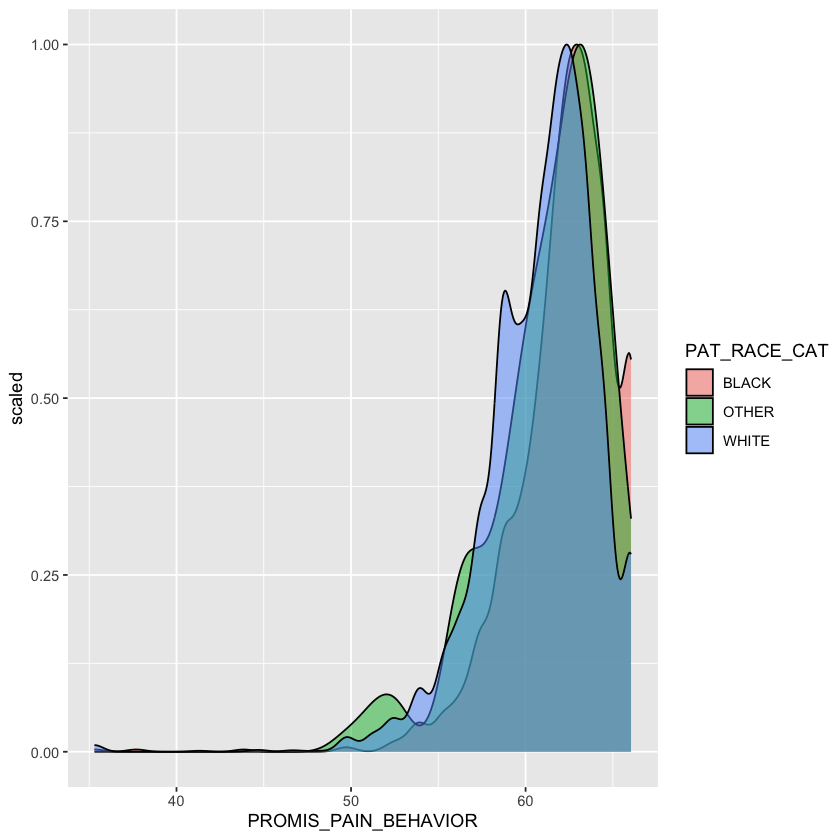

In [34]:
pain_df$PAT_RACE_CAT <- as.factor(ifelse(pain_df$PAT_RACE %in% c("BLACK", "WHITE"), pain_df$PAT_RACE, "OTHER"))
ggplot(pain_df) + geom_density(aes(x = PROMIS_PAIN_BEHAVIOR, y = ..scaled.., fill = PAT_RACE_CAT), alpha = 0.5)

aov_res <- aov(PROMIS_PAIN_BEHAVIOR~PAT_RACE_CAT, data=pain_df)
summary(aov_res)

3. Examine the association between `CCI_BIN` and `MEDICAID_BIN`. Are these variable significantly related to each other? How would you describe their relationship?

In [35]:
chi_sq <- chisq.test(pain_df$CCI_BIN, 
           pain_df$MEDICAID_BIN)
chi_sq
chi_sq$p.value


	Pearson's Chi-squared test with Yates' continuity correction

data:  pain_df$CCI_BIN and pain_df$MEDICAID_BIN
X-squared = 6.4049, df = 1, p-value = 0.01138


[1] 0.01138041

4. Create a table of the percentages of people with pain in each region of the body stratified by whether or not they had follow up information, and add p_values to the table. Which body regions were selected significantly more for those with follow-up compared to those without?

In [36]:
pain_df <- pain_df %>% mutate(Back = ifelse(if_any(c(X208, X209, X218, X219, X212, X213),  ~ . == 1), 1, 0),
                             Neck = ifelse(if_any(c(X105, X106, X205, X206),  ~ . == 1), 1, 0),
                             Shoulders = ifelse(if_any(c(X107, X110, X207, X210),  ~ . == 1), 1, 0),
                             Chest_Abs = ifelse(if_any(c(X108, X109, X112, X113),  ~ . == 1), 1, 0),
                             Legs = ifelse(if_any(c(X126, X127, X228, X229, X131, X132, X233, X234),  ~ . == 1), 1, 0),
                             Arms = ifelse(if_any(c(X111, X114, X211, X214, X115, X116, X117, X118, X217, X220),  ~ . == 1), 1, 0),
                             Wrists_Hands = ifelse(if_any(c(X119, X124, X221, X226, X125, X128, X227, X230),  ~ . == 1), 1, 0),
                             Elbows = ifelse(if_any(c(X215, X216),  ~ . == 1), 1, 0),
                             Feet_Ankles = ifelse(if_any(c(X135, X136, X237, X238, X133, X134, X235, X236),  ~ . == 1), 1, 0),
                             Knees = ifelse(if_any(c(X129, X130, X231, X232),  ~ . == 1), 1, 0),
                             Head = ifelse(if_any(c(X101, X102, X103, X104, X201, X203, X202, X204),  ~ . == 1), 1, 0),
                             Hips = ifelse(if_any(c(X120, X121, X122, X123, X222, X223, X224, X225),  ~ . == 1), 1, 0))


tbl_summary(pain_df, include = c(Back, Neck, Shoulders, Chest_Abs, Legs, Arms, 
                                 Wrists_Hands, Elbows, Feet_Ankles, Knees, Head, Hips),
           by = "HAS_FOLLOW_UP") %>% 
  add_p() %>%
  as_gt() %>% 
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)